In [1]:
from utils import *
%load_ext autoreload
%autoreload 2

In [2]:
data = prepare_mnist_data()
data.keys()

dict_keys(['trainX', 'trainY', 'testX', 'testY'])

In [3]:
import numpy as np

X = np.random.rand(10, 10)
X.shape

(10, 10)

In [4]:
from scipy.optimize import linprog, milp, LinearConstraint

def solve_l1_Ax_b(A, b, constrained=True):
    # Solve min ||Ax-b||_1
    # s.t. x>=0, 1^Tx=1, x integer
    m, n = A.shape
    c = np.concatenate((np.zeros(n), np.ones(m)))
    A_ub = np.block([
        [-np.identity(n), np.zeros((n, m))], 
        [A, -np.identity(m)],
        [-A, -np.identity(m)]
    ])
    A_eq = np.block(
        [np.ones((1, n)), np.zeros((1, m))]
    )
    b_ub = np.concatenate((np.zeros(n), b, -b))
    b_eq = 1
    constraints = [
        LinearConstraint(A_ub, ub=b_ub),
    ]
    if constrained:
        constraints.append(LinearConstraint(A_eq, 1, 1))
        integrality = np.concatenate((np.ones(n), np.zeros(m)))
        sol = milp(c=c, integrality=integrality, constraints=constraints)
    else:
        sol = milp(c=c, constraints=constraints)
    return sol["x"][: n]

In [5]:
A = prepare_mnist_data()["trainX"].T

In [6]:
sol = solve_l1_Ax_b(A[:, :4], A[:, 5])
np.argmax(sol)

1

In [7]:
# A - WH
W = A[:, np.random.randint(0, 100, 3)]
H = np.zeros((3, A.shape[1]))
for i in range(A.shape[1]):
    H[:, i] = solve_l1_Ax_b(W, A[:, i])

In [73]:
for i in range(A.shape[0]):
    W[i, :] = solve_l1_Ax_b(H.T, A[i, :], constrained=False)

In [92]:
from MySolution import MyClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

x = StandardScaler(data["trainX"])

c = MyClustering(K=3)
c.train(data["trainX"])

IndexError: index 1423 is out of bounds for axis 0 with size 1000

In [78]:
def solve_l1_l1_Ax_b(A, b, beta):
    # min ||Ax - b||_1 + beta * ||x||_1
    m, n = A.shape
    c = np.concatenate((np.zeros(n), np.ones(m), beta*np.ones(n)))
    A_ub = np.block([
        [A, -np.identity(m), np.zeros((m, n))],
        [-A, -np.identity(m), np.zeros((m, n))],
        [-np.identity(n), np.zeros((n, m)), np.zeros((n, n))],
        [np.identity(n), np.zeros((n, m)), -np.identity(n)]
    ])
    b_ub = np.concatenate((b, -b, np.zeros(n), np.zeros(n)))
    sol = linprog(c=c, A_ub=A_ub, b_ub=b_ub)
    return sol['x'][: n]

def solve_l1_linf_Ax_b(A, b, beta):
    m, n = A.shape
    c = np.concatenate((np.zeros(n), np.ones(m), beta*np.ones(1)))
    A_ub = np.block([
        [A, -np.identity(m), np.zeros((m, 1))],
        [-A, -np.identity(m), np.zeros((m, 1))],
        [-np.identity(n), np.zeros((n, m)), np.zeros((n, 1))],
        [np.identity(n), np.zeros((n, m)), -np.ones((n, 1))]
    ])
    b_ub = np.concatenate((b, -b, np.zeros(n), np.zeros(n)))
    sol = linprog(c=c, A_ub=A_ub, b_ub=b_ub)
    return sol['x'][: n]

In [81]:
# A - WH
from tqdm import tqdm
W = A[:, np.random.randint(0, 100, 3)]
H = np.zeros((3, A.shape[1]))
for _ in tqdm(range(5)):
    for i in range(A.shape[1]):
        H[:, i] = solve_l1_l1_Ax_b(W, A[:, i], 0.5)
    for i in range(A.shape[0]):
        W[i, :] = solve_l1_linf_Ax_b(H.T, A[i, :], 0.1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.33s/it]


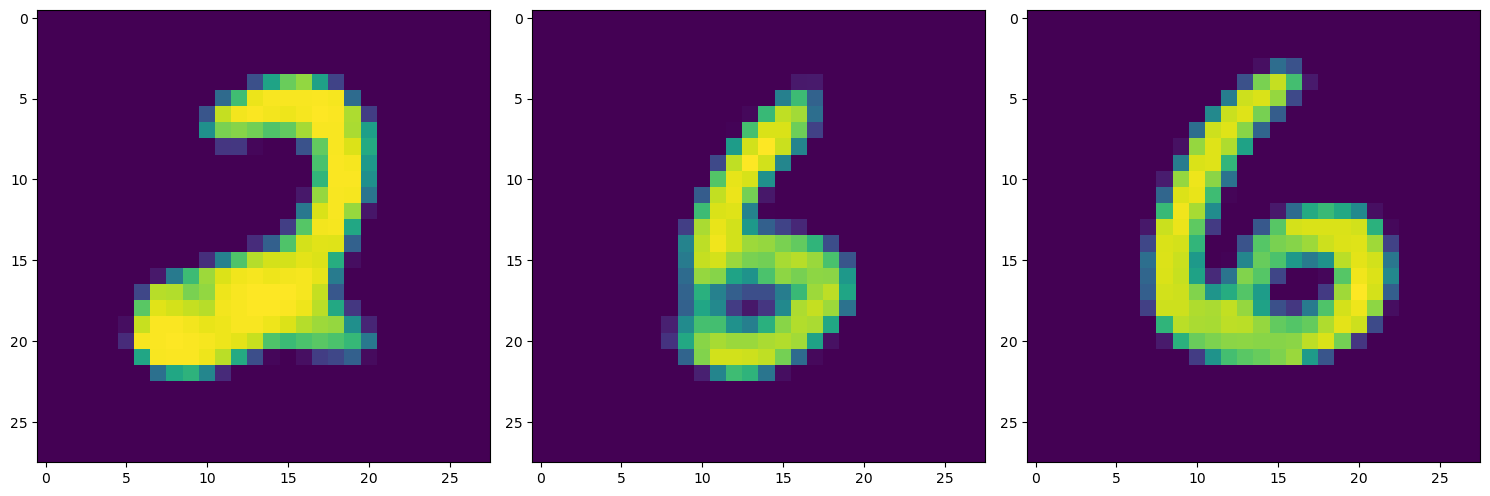

In [83]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axes[i].imshow(W[:, i].reshape(28, 28))

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [1]:
l = LabelSelection(0.25)

NameError: name 'LabelSelection' is not defined

In [ ]:
def evaluate_clustering(trainY):
    label_reference = align_cluster_labels(self.labels, trainY)
    aligned_labels = align_cluster_labels(self.labels, label_reference)
    nmi = normalized_mutual_info_score(trainY, aligned_labels)

    return nmi


def evaluate_classification(self, trainY, testX, testY):
    pred_labels = self.infer_cluster(testX)
    label_reference = self.align_cluster_labels(self.labels, trainY)
    aligned_labels = self.align_cluster_labels(pred_labels, label_reference)
    accuracy = accuracy_score(testY, aligned_labels)

    return accuracy


def get_class_cluster_reference(cluster_labels, true_labels):
    ''' assign a class label to each cluster using majority vote '''
    label_reference = {}
    for i in range(len(np.unique(cluster_labels))):
        index = np.where(cluster_labels == i,1,0)
        num = np.bincount(true_labels[index==1]).argmax()
        label_reference[i] = num

    return label_reference


def align_cluster_labels(cluster_labels, reference):
    ''' update the cluster labels to match the class labels'''
    aligned_lables = np.zeros_like(cluster_labels)
    for i in range(len(cluster_labels)):
        aligned_lables[i] = reference[cluster_labels[i]]

    return aligned_lables